# 5.e) Round function properties
This notebook will review the properties of the round function and verify some of the code.  The proper design of the round function is critical to the security of the algorithm.  Desirable properties of the round function are 
nonlinearity, diffusion, confusion and avalanche effect.  
- Nonlinearity: The cipher algorithm derives its nonlinearity from the round function.  If the round function is a linear function, then the operations could be replaced by linear equations and Gaussian elimination can be performed to solve for the key.  Since the algorithm consists of four rounds of the Feistel network, non-invertibility of the round function is important to prevent back solving for the key algebraically.  Nonlinearity and invertibility are obtained with the S-Box and the Mixer matrix components of the round function.  
- Diffusion: The cipher algorithm alters the statistical structure of the plaintext to thwart frequency analysis.  The Mixer matrix, the S-Box along with the P-table implement diffusion by changing the character statistics in the plaintext by transposition and permutation of the original order.
- Confusion: The cipher algorithm implements confusion by character substitution.  This is implemented in the cipher by  the S-Box function and the Mixer matrix.
- Avalanche effect: Avalanche effect is a feature of the cipher algorithm where changing one character in the input causes many characters in the output block to change.  The use of the Mixer matrix causes all the characters in the output to change. 

Notebook Sections:   
- [1) Round function linearity](#section5e1)
- [2) Inverse round function](#section5e2)
- [3) Round function verification](#section5e3)
- [4) Section summary](#section5e4)
- [5) References](#section5e5)

**ToDo:**  
- ~~finish verification section~~
- ~~write inv_RF() function, needed for PT attack~~
- ~~remove old Mixer matrix code~~
- expand narration
- ~~clean up code for inv_S_box~~
- ~~finish section summary~~
- spell check

In [38]:
from collections import Counter
import itertools
import random
import pickle
import sys
import numpy as np
import matplotlib.pyplot as plt
from myModule import *

In [39]:
# Loading objects created in the main notebook.
with open('objs.pkl', 'rb') as f:
    block_size,PT,PT_int,key,IV,Mixer,S_box,P_table,en_letter_freq = pickle.load(f)

## 1) Round function linearity <a id="section5e1"></a>
The following code examines the non-linearity of the round function. A linear function is a function whose graph is a straight line.  The other properties of a linear function are $f(a+b) = f(a)+f(b)$ and $f(ax) = af(x)$.  To demonstrate that the round function is nonlinear, the input versus output will be plotted to see if a straight line results and the relation $f(a+b) = f(a)+f(b)$ and $f(ax) = af(x)$ will be examined.

### Plotting round function output vs input
The following plot is made with the first element of the input vector, A, set to an increasing count while the output is saved.  The first element of the output of the is plotted.  Then the second element in the input is set to an increasing count and the results are also plotted.  Only three columns are plotted to keep the graph from getting too messy. 

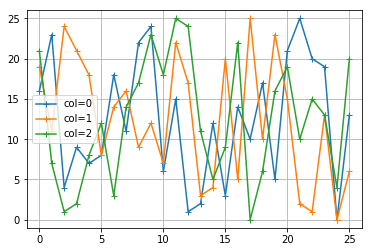

In [40]:
K = np.zeros(int(block_size/2),dtype=np.uint8) # null key
#col = np.arange(8)
for col in range(3):
    A = np.zeros((26,int(block_size/2)), dtype=np.uint8)
    Y = np.zeros(26)

    for i in range(26):
        A[i][col] = i

    for i in range(26):
        Y[i]=RF(A[i],K)[col]

    plt.plot(Y,'-+',label='col={:d}'.format(col))

plt.xlim((-1,26))
plt.ylim((-1,26))
plt.legend()
plt.grid()
plt.show()

The output of the round function is obviously not a straight line. To keep the plot cleaner, only a few results are plotted.

### Testing for $f(a+b) = f(a)+f(b)$ 
In this test, the first element of the input vector is set to an increasing count.  The first element in the test vector B is set to a constant and the key is set to zero.  The results of $f(a)+f(b)$ and $f(a+b)$ are plotted to see if they are the same.

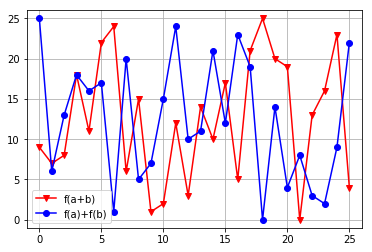

In [41]:
A = np.zeros((26,int(block_size/2)), dtype=np.uint8)
Y1 = np.zeros(26)
Y2 = np.zeros(26)
B = np.array([3, 0, 0, 0, 0, 0, 0, 0],dtype=np.uint8) # more test data
K = np.zeros(int(block_size/2),dtype=np.uint8) # null key
col = 0

for i in range(26):
    A[i][col] = i

for i in range(26):
    Y1[i]=RF((A[i]+B) % 26,K)[col]
    Y2[i]=(RF(A[i],K)[col] + RF(B,K)[col]) % 26

plt.plot(Y1,'-vr',label='f(a+b)')
plt.plot(Y2,'-ob',label='f(a)+f(b)')
plt.xlim((-1,26))
plt.ylim((-1,26))
plt.legend()
plt.grid()
plt.show()

As can be seen in the plot above, $f(a+b) \neq f(a)+f(b)$, so this test for linearity fails.

### Testing for $f(ax) = af(x)$ 
The plot below is set up the same way.

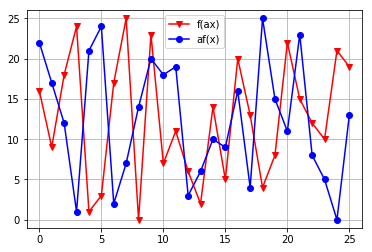

In [42]:
A = np.zeros((26,int(block_size/2)), dtype=np.uint8)
Y1 = np.zeros(26)
Y2 = np.zeros(26)
B = np.array([3, 0, 0, 0, 0, 0, 0, 0],dtype=np.uint8) # more test data
col = 0

for i in range(26):
    A[i][col] = i

for i in range(26):
    Y1[i]=RF(A[i]*3 % 26,K)[col]
    Y2[i]=3*RF(A[i],K)[col] % 26

plt.plot(Y1,'-vr',label='f(ax)')
plt.plot(Y2,'-ob',label='af(x)')
plt.xlim((-1,26))
plt.ylim((-1,26))
plt.legend()
plt.grid()
plt.show()

As can be seen in the plot above, $f(ax) \neq af(x)$, so this test for linearity fails.  

The output of the round function is not a straight line, $f(a+b) \neq f(a)+f(b)$ and $f(ax) \neq af(x)$, therefore the round function is nonlinear.

## 2) Inverse round function <a id="section5e2"></a>
In this section the inverse of the round function is examined.  The round function is composed of several components.  These are char_xor(), mixer matrix dot product, S-Boxes and the P-table.  If an inverse function can be found for each component, then they could be used to construct an inverse round function.  The inverse round function could be used to aid in breaking the cipher.  However, as shown below, the Mixer matrix does not have an integer inverse, therefore and algebraic inverse to the round function can't be constructed.  

### Char XOR
The inverse character xor has an inverse function which is, inv_char_xor().  This function is used in the decryption function.

### Mixer matrix inverse
The Mixer matrix is not unimodular therefore an integer inverse of the matrix does not exist.  A matrix is unimodular if the determinant of the matrix is equal to $\pm1$ [1].  The Mixter matrix and its determinant is shown below.

In [43]:
print(Mixer)
print('the determinate of Mixer is: {:.1f}'.format(np.linalg.det(Mixer)))

[[2 1 3 1 5 1 7 1]
 [1 2 1 3 1 5 1 7]
 [7 1 2 1 3 1 5 1]
 [1 7 1 2 1 3 1 5]
 [5 1 7 1 2 1 3 1]
 [1 5 1 7 1 2 1 3]
 [3 1 5 1 7 1 2 1]
 [1 3 1 5 1 7 1 2]]
the determinate of Mixer is: 1535625.0


The determinate is $\ne \pm1$, therefore an inverse integer matrix does not exist. An inverse integer matrix is needed to algebraically solve for the input vector.  

A floating point inverse matrix can't be used to solve for the input since modulo 256 multiplication and modulo 26 addition have been used in the round function.  This is illustrated in the following code.  

The inverse of the Mixer matrix can be obtained using the linear algebra tools in numpy and is shown below.  

In [44]:
inv_Mixer = np.linalg.inv(Mixer)
inv_Mixer

array([[-0.12776557, -0.003663  ,  0.1789011 , -0.003663  , -0.00776557,
        -0.003663  ,  0.0189011 , -0.003663  ],
       [-0.003663  , -0.12776557, -0.003663  ,  0.1789011 , -0.003663  ,
        -0.00776557, -0.003663  ,  0.0189011 ],
       [ 0.0189011 , -0.003663  , -0.12776557, -0.003663  ,  0.1789011 ,
        -0.003663  , -0.00776557, -0.003663  ],
       [-0.003663  ,  0.0189011 , -0.003663  , -0.12776557, -0.003663  ,
         0.1789011 , -0.003663  , -0.00776557],
       [-0.00776557, -0.003663  ,  0.0189011 , -0.003663  , -0.12776557,
        -0.003663  ,  0.1789011 , -0.003663  ],
       [-0.003663  , -0.00776557, -0.003663  ,  0.0189011 , -0.003663  ,
        -0.12776557, -0.003663  ,  0.1789011 ],
       [ 0.1789011 , -0.003663  , -0.00776557, -0.003663  ,  0.0189011 ,
        -0.003663  , -0.12776557, -0.003663  ],
       [-0.003663  ,  0.1789011 , -0.003663  , -0.00776557, -0.003663  ,
         0.0189011 , -0.003663  , -0.12776557]])

Multiplying the Mixer matrix by its inverse does result in the identity matrix.  Converting the Mixer matrix to floating point and calculating the inverse, which is the identity matrix, once small non-zero values are converted to zero.  

In [45]:
tol = 1e-10
ans = (Mixer.astype(float) @ inv_Mixer)
ans[ans < tol] = 0.0
ans

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

This demonstrates that a floating point inverse exists, but as demonstrated below, the inverse can't be used to solve for the input when modulo math is involved.  

In [46]:
# make an input test vector, X
X = np.array([1,5,9,11,15,17,19,25],dtype=np.uint8).flatten()
print(X)

[ 1  5  9 11 15 17 19 25]


In [47]:
# math performed with uint8 data type
Y = (Mixer @ X) % 26
print(Y)

[13 13 15 21  5 21 15  1]


The result is valid for modulo 256 multiplication and modulo 26 addition.

Now we convert the data type to full resolution integers and do the calculation over.

In [48]:
# allowing math to be done with int64 data type where multiplication and addition don't exceed the word length 
Y = (Mixer.astype(int) @ X.astype(int)) % 26
print(Y)

[ 9  9 15 17  5 21 15 23]


The above calculations show that since the results are different, $\text{modulo }(2^8+1)$ math is giving different results. 

Now doing the matrix operation with modulo 256 multiplication and modulo 26 addition as is done in the round function.

In [49]:
Y = (Mixer @ X) % 26
print(Y)

[13 13 15 21  5 21 15  1]


Trying to solve for X, gives the following result:

In [50]:
(inv_Mixer @ Y) % 26

array([ 1.06212454,  1.7759707 , 24.90212454,  1.1359707 ,  2.02212454,
       23.6159707 ,  0.18212454,  2.2559707 ])

Result is not correct.  Modulo 256 multiplication and modulo 26 addition are complicating the inverse matrix calculation.  The inverse calculation only works if the data types are adjusted so that overflow is prevented.

The equivalency property in modulo math means that many solutions for inverse exist.  The following code illustrates the property.  We multiply two vectors using modulo 256 multiplication and modulo 26 addition and look at the results.  The vector A, is equal to the first row in the Mixer matrix and the vector X, is a series of vectors where each element is changed from 0 to 25, which is the possible range character values.  Using some for loops, we can step through a table of values for X.  A snippet of the table is shown below.  Y is the output of the vector multiplication modulo 256 and modulo 26 addition.
```
X= [25 25 25 23  0  0  0  0]  Y= 17
X= [25 25 25 24  0  0  0  0]  Y= 18
X= [25 25 25 25  0  0  0  0]  Y= 19
X= [25 25 25 25  1  0  0  0]  Y= 24
X= [25 25 25 25  2  0  0  0]  Y= 3
X= [25 25 25 25  3  0  0  0]  Y= 8
X= [25 25 25 25  4  0  0  0]  Y= 13
X= [25 25 25 25  5  0  0  0]  Y= 18
X= [25 25 25 25  6  0  0  0]  Y= 23
X= [25 25 25 25  7  0  0  0]  Y= 2
X= [25 25 25 25  8  0  0  0]  Y= 7
X= [25 25 25 25  9  0  0  0]  Y= 12
X= [25 25 25 25 10  0  0  0]  Y= 17
X= [25 25 25 25 11  0  0  0]  Y= 22
X= [25 25 25 25 12  0  0  0]  Y= 1
X= [25 25 25 25 13  0  0  0]  Y= 6
X= [25 25 25 25 14  0  0  0]  Y= 11
```
As can be seen in the table, there is not a one to one relation of the product of $A*X$ to $Y$.  This shows the equivalency.  

We can count the frequency of the outputs in the full table as shown in the histogram.

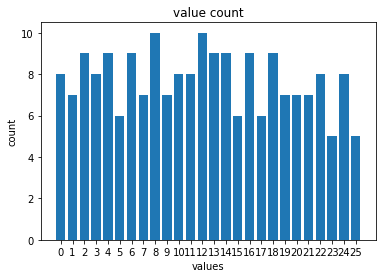

In [51]:
A = np.array([2, 1, 3, 1, 5, 1, 7, 1], dtype=np.uint8)
X = np.zeros(len(A), dtype=np.uint8)
Y = []
for i in range(len(X)):
    if i > 0:
        for j in range(1,26):
            X[i] = j
            #print('X=',X,' Y=',(A @ X) % 26)
            Y.append((A @ X) % 26)
    else:
        for j in range(26):
            X[i] = j
            #print('X=',X,' Y=',(A @ X) % 26)
            Y.append((A @ X) % 26)

# using collections.Counter() to count of each element 
cnt = Counter(Y) 
sorted_dict = {key: value for key, value in sorted(cnt.items())}

# plot the histogram of the Y values
plt.bar(range(len(sorted_dict)), sorted_dict.values(), align='center')
plt.xticks(range(len(sorted_dict)), list(sorted_dict.keys()))
plt.title('value count')
plt.ylabel('count')
plt.xlabel('values')
plt.show()

The histogram shows the equivalency of the output to multiple inputs for the modulo math.  This small example shows that input to the Mixer matrix would be hard to figure out from the product.  

### Inverse S-box
The following code builds the inverse of the S-Box.  This allows us to unwind the substitutions performed by the S-Box. 

In [52]:
inv_S_box = np.copy(S_box) # make a copy of the S-Box so it has the same shape.

for i in range(len(inv_S_box)): # runs 0 to 7
    for j in range(len(inv_S_box[0])): # runs 0 to 25
        inv_S_box[i][S_box[i][j]] = j

Testing the inverse S-Box.

In [53]:
X = np.arange(8, dtype=np.uint8)  # make a test vector
print(X)

[0 1 2 3 4 5 6 7]


In [54]:
# index the S-Box with the test vector to generate the outputs
Y = np.ones(int(block_size/2),dtype=np.uint8)
for i in range(int(block_size/2)):
    Y[i] = S_box[i][X[i]]
print(Y) # S-Box output

[17  3 24  0  8 11 15 11]


In [55]:
inv_S_box_test_out = np.zeros(8, dtype=np.uint8 )
for i in range(int(block_size/2)):
    inv_S_box_test_out[i] = inv_S_box[i][Y[i]]   

print(inv_S_box_test_out)

[0 1 2 3 4 5 6 7]


The inverse works, since we got back the starting vector.

#### Inverse P-table
The inverse P-table can be built in the same way.

In [56]:
P_table

array([7, 2, 6, 5, 0, 4, 3, 1], dtype=uint8)

Testing the inverse P-table

In [57]:
inv_P_table = np.ones(len(P_table), dtype=np.uint8)
for i in range(len(P_table)):
    inv_P_table[P_table[i]] = i

In [58]:
inv_P_table

array([4, 7, 1, 6, 5, 3, 2, 0], dtype=uint8)

**Observation:** Algebraic inverses were derived for all components of the round function except for the Mixer matrix.  Since the cipher algorithm has four rounds, the absence of an inverse function makes cryptanalysis more difficult.    

## 3) Round function verification <a id="section5e3"></a>
The following code runs through some basic tests of the functions used in the round function.  This  is only a quick check of the code.

### Char XOR verification
The Char XOR function is modulo 26 addition in place of the bitwise XOR usually used in encryption algorithms.

In [59]:
X1 = np.array([1,0,0,0,0,0,0,0], dtype=np.uint8)  # test vector
X2 = np.array([1,0,0,1,0,0,0,0], dtype=np.uint8)  # test vector
char_xor(X1,X2)

array([2, 0, 0, 1, 0, 0, 0, 0], dtype=uint8)

In [60]:
X1 = np.array([1,0,0,0,0,0,0,0], dtype=np.uint8)  # test vector
X2 = np.array([1,0,0,1,0,0,0,0], dtype=np.uint8)  # test vector
inv_char_xor(X1,X2)

array([ 0,  0,  0, 25,  0,  0,  0,  0], dtype=uint8)

The results above show the proper operation of the Char XOR function.  

It takes 25 char_xor() repeats to get back to the same value.

In [61]:
# repeated char_xor operation
X = np.array([7], dtype=np.uint8)  # test vector
Y = np.array([5], dtype=np.uint8)  # test vector
Y0 = Y
for i in range(40):
    Y = char_xor(X,Y)
    if Y == Y0:
        print(i,Y)


25 [5]


### Mixer matrix verification
Test for mixer diffusion and proper multiplication.  The mixer matrix is used to spread the effects of individual characters across the half block during the calculations.  Changing one character in the half block will cause several characters in the output to also change.

Testing the operation of matrix multiplication.  Multiplying an N by N matrix by a 1-D vector using the @ operator

In [62]:
X = np.array([1,1,1,1,1,1,1,1], dtype=np.uint8)  # test vector
print((Mixer @ X) % 26)

[21 21 21 21 21 21 21 21]


In [63]:
Mixer

array([[2, 1, 3, 1, 5, 1, 7, 1],
       [1, 2, 1, 3, 1, 5, 1, 7],
       [7, 1, 2, 1, 3, 1, 5, 1],
       [1, 7, 1, 2, 1, 3, 1, 5],
       [5, 1, 7, 1, 2, 1, 3, 1],
       [1, 5, 1, 7, 1, 2, 1, 3],
       [3, 1, 5, 1, 7, 1, 2, 1],
       [1, 3, 1, 5, 1, 7, 1, 2]], dtype=uint8)

The output vector should have element equal to $7+5+3+2+4*1=21$ because each row is a rotated version of $[7, 1, 5, 1, 3, 1, 2, 1]$

A change in one element will cause multiple outputs to be different.

In [64]:
X1 = np.array([1,0,0,0,0,0,0,0], dtype=np.uint8)  # test vector
X2 = np.array([1,0,0,1,0,0,0,0], dtype=np.uint8)  # test vector

((Mixer @ X1) % 26) == ((Mixer @ X2) % 26)

array([False, False, False, False, False, False, False, False])

### S-Box verification
Some operations are performed on the S-Box to verify the code.  This is not a comprehensive verification.

In [65]:
X = np.arange(8, dtype=np.uint8)
print(X)

[0 1 2 3 4 5 6 7]


In [66]:
# run each element of S_box_in through the S_box matrix as an index
Y = np.ones(int(block_size/2),dtype=np.uint8)
for i in range(int(block_size/2)):
    Y[i] = S_box[i][X[i]]
print(Y)

[17  3 24  0  8 11 15 11]


In [67]:
S_box[3]

array([ 1, 23, 13,  0, 10, 18, 25, 20,  2,  6, 14, 19,  5, 24, 16, 17,  8,
        4, 22, 15,  3, 12, 11,  9, 21,  7], dtype=uint8)

We can see that the third element of Y is the same as the third element of $\text {S_box}[3]$.

Check: $S(a_{i,j})\neq a_{i,j}$  
In combinatorial mathematics, a derangement is a permutation of the elements of a set, such that no element appears in its original position.

In [68]:
for i in range(len(S_box)): # runs 0 to 7
    for j in range(len(S_box[0])): # runs 0 to 25
        if S_box[i][j] == j:
            print('got match in S({:d},{:d})'.format(i,j))
print('done')

done


No fixed points were found.

Check for opposite fixed points, $S(a_{i,j}) \neq {a_{i,j}^{-1}\text{ mod } 26}$. 

In [69]:
for i in range(len(S_box)): # runs 0 to 7
    for j in range(len(S_box[0])): # runs 0 to 25
        if S_box[i][j] == np.mod(np.invert(j),26):
            print('got match in S({:d},{:d}) = {:d}'.format(i,j,S_box[i][j]))
print('done')

done


No opposite fixed points were found.  

### P-table verification
Some operations are performed on the P-table to verify the code.  This is not a comprehensive verification.
Run a count through the P-table

In [70]:
print(P_table)

[7 2 6 5 0 4 3 1]


In [71]:
#X = np.array([0,1,2,3,4,5,6,7],dtype=np.uint8)
X = np.arange(8, dtype=np.uint8)
Y = np.copy(X)
for i in range(len(X)):
    Y[i] = X[P_table[i]]
print('Y=',Y)
Y == P_table

Y= [7 2 6 5 0 4 3 1]


array([ True,  True,  True,  True,  True,  True,  True,  True])

In [72]:
# doing the same to check the inverse table
for i in range(len(X)):
    X[i] = Y[inv_P_table[i]]
print('X=',X)

X= [0 1 2 3 4 5 6 7]


#### repeated P-table operation

In [73]:
# repeated P-table operation
X = np.arange(8, dtype=np.uint8)  # test vector
Y = np.copy(X)  # test vector
X0 = np.copy(X)
for i in range(20):
    for j in range(len(X)):
        Y[j] = X[P_table[j]]
    if ((Y - X0) % 26).sum() == 0:
        print(i,Y)
    X = np.copy(Y)


7 [0 1 2 3 4 5 6 7]
15 [0 1 2 3 4 5 6 7]


After 8 rounds of the P-table, the shuffle is back to original order. 

## 4) Section summary <a id="section5e4"></a>
In this section some properties of the round function were examined.  Inverse functions were examined.  No inverse for the Mixer matrix was found.  A small amount of verification code was written to test the basic operations of some of the functions.

## 5) References <a id="section5e5"></a>
1. Wikipedia contributors. (2020, September 8). Unimodular matrix. In Wikipedia, The Free Encyclopedia. Retrieved 13:40, February 13, 2021, from https://en.wikipedia.org/w/index.php?title=Unimodular_matrix

In [74]:
stop

NameError: name 'stop' is not defined

#### repeated S-Box operation
can look for 8-gram frequency as a function of starting X    
No simple repeats, so moved here to work on later   

In [ ]:
# repeated S-Box operation
#X = np.ones(8, dtype=np.uint8)  # test vector
X = np.arange(8, dtype=np.uint8)  # test vector
print('X=',X)
#Y = np.copy(X)  # test vector
X0 = np.copy(X)
for i in range(76):
    Y = (Mixer @ X) % 26
    print(i,Y)
    X = np.copy(Y)


In [ ]:
# repeated S-Box operation
#X = np.ones(8, dtype=np.uint8)  # test vector
#X = np.arange(8, dtype=np.uint8)  # test vector
X = np.array([0, 0, 2, 3, 4, 5, 6, 7], dtype=np.uint8)  # test vector
print('X=',X)
#Y = np.copy(X)  # test vector
#X0 = np.copy(X)
#X0 = np.array([8, 5, 6, 9, 8, 5, 6, 9], dtype=np.uint8)  # look for this in the output, only shows once
X0 = np.array([ 6, 25,  8, 15,  6, 25,  8, 15], dtype=np.uint8)  # look for this in the output, shows after 20
#X0 = np.array([20, 21, 18, 25, 20, 21, 18, 25], dtype=np.uint8)  # look for this in the output
for i in range(2000):
    Y = (Mixer @ X) % 26
    if ((Y - X0) % 26).sum() == 0:
        print(i,Y)
    X = np.copy(Y)


#### repeated round function operation
can look for 8-gram repeats as a function of starting value.  
No simple repeats, so moved here to work on later   

In [ ]:
K = np.ones(8, dtype=np.uint8)  # null key
#X = np.ones(8, dtype=np.uint8)  # test vector
X = np.zeros(8, dtype=np.uint8)  # test vector
#X = np.arange(8, dtype=np.uint8)  # test vector
print('X=',X)
#Y = np.copy(X)  # test vector
X0 = np.copy(X)
for i in range(76):
    Y = RF(X,K)  #(Mixer @ X) % 26
    print(i,Y)
    X = np.copy(Y)
